# EVeMa 2018

![logo](assets/logo.jpg "Logo")

- Instructor: Juan Esquivel.

- Authors: 
    - Saúl Calderón, Martín Solís, Ángel García, Blaž Meden, Žiga Emeršič, Felipe Meza, Juan Esquivel
    - Mauro Méndez, Manuel Zumbado. 

# Introduction to Data Science
This workshop has the main objective of giving attendees a basic understanding of the different aspects involved in the day-to-day tasks performed by the data scientist role. Note that the definition of what Data Science actually is can be vague. However, some of the core competencies that need to be taught are:

- **Reading and transforming data at large scale**. This falls under the standard ETL philosophy where data needs to be *Extracted* from a source, it needs to be *Transformed* either to create more complex data or to adjust to the target destination and, finally, data needs to be *Loaded* into a medium where it will be consumed by users. Over the last decade the need to handle the ETL process at scale has become key to the effectiveness of a data scientist. In this workshop we will use Apache Spark as a way to introduce participants into this type of processing.

- **Data Analytics**. A broad term that covers applying techniques that allow us to make the data more compact and thus interpretable. The methodology behind the analyses can range from very ad hoc analysis, such as running SQL queries and averaging columns of interest, to formal statistical tests to compare multiple sets of data to determine similarity, for instance. What framework the analytics takes place in can vary wildly depending on the data stack that a particular organization uses. However, statistical frameworks like `R` are common. Python tends to be the language of choice for science-based projects and it has matured into a very robust option, thanks to the vast number of libraries available.

- **Learning**. A data scientist will not necessarily develop new machine learning algorithms but he/she should be able to apply them to specific problems that are faced. For instance, by doing analytics we could identify purchasing patterns by customers at a particular store. Are these patterns systematic enough that we can predict, given products already purchased, what other products that client might be interested in? At what price range? Would the client need an offer to decide to purchase the product? All of these are questions that could be answered by learning a model. Scikit learn is the de facto library in Python. Frameworks like Tensorflow and Keras (which can wrap Tensorflow) are also available as APIs in Python.

- **Experiment design and execution**. Related to the *Science* part in *Data Science*, it is not uncommon for a person in this role to think about validating the trends and conjectures made from the analysis in order to create verifiable knowledge. For example, if a social media website release a change in their UI and see a 20% increase in engagement the 5 days after the release, is it due to the UI changes or was there some social event affecting a large population that coincided with that release? How do we know for sure that it was the product change? This is where designing experiments comes in and it goes from defining target populations, sampling strategies to formal statistical testing.

- **Visualization**. It could be considered more intimately related to analytics, however, visualization is ubiquitous in everything a data scientist does. The person will not necessarily develop novel visualizations but should be aware of effective ways of showing the data in aggregate fashion to the consumers. It can range from relatively simple plotting with libraries like `matplotlib` to potentially very expensive cloud packages, like *Tableau*.

# Data processing at large scale
Nowadays it is relatively simple to have vast amounts of organizational data without even realizing it. Both local and cloud storage services give us the ability to store a significant amount of information about customers, transactions, projects, and so on. Without even realizing it, after a couple of years, an analysis program that *used to work* can stop working just because of the organic data growth.

As mentioned before, one of the core competencies of a data scientist is to be able to process large amounts of data. This is commonly done using high scalability frameworks inspired by a programming model called *MapReduce*. In essence, the idea is to think about data as a large number of single records and we want to apply specific operations to each of them, independent of any other record (at least in theory). These operations that modify the records are called *map* functions. In addition to mapping an input to a transformed output we can sythesize multiple records that correspond to the same entity by *reducing* them from multiple records into one. While current frameworks do not necessarily hold to the exact spirit of *MapReduce* the ideas are the same.

To serve as an example we will assume there is an online retailer that stores customer purchases in a PostgreSQL database and we will apply some basic operations on it to illustrate what these types of frameworks can do. A sample creation script for such a table, with a handful of transaction examples is given below:

```sql
CREATE TABLE transactions (
  id SERIAL PRIMARY KEY,
  customer_id integer NOT NULL,
  amount integer NOT NULL,
  purchased_at timestamp without time zone NOT NULL
);


INSERT INTO "transactions" (customer_id, amount, purchased_at) VALUES
(1, 55, '2017-03-01 09:00:00'),
(1, 125, '2017-03-01 10:00:00'),
(1, 32, '2017-03-02 13:00:00'),
(1, 64, '2017-03-02 15:00:00'),
(1, 128, '2017-03-03 10:00:00'),
(2, 333, '2017-03-01 09:00:00'),
(2, 334, '2017-03-01 09:01:00'),
(2, 333, '2017-03-01 09:02:00'),
(2, 11, '2017-03-03 20:00:00'),
(2, 44, '2017-03-03 20:15:00');
```

## Apache Spark and distributed processing

There are multiple frameworks that can be used for large scale data processing. For the purposes of this workshop we will use *Apache Spark* because it has widespread adoption, it is an open project and it also has cloud support from commercial cloud vendors (like Amazon Web Services).

Spark is based on an abstraction called *Resilient Distributed Dataset* which is a collection of elements that can be stored (temporarily or permanently) across multiple nodes in a cluster. Spark supports multiple sources of information, from SQL and NoSQL driven databases, to simple text files. Transformation operations are applied on RDDs and a programmer's main job centers around designing a series of operations that need to be applied to a source dataset in order to transform it into the final output desired.

The following snippet shows a basic example to read a transactions table from a database and display its contents. Note that if the table were big, calling the `show()` method is unwise.

In [1]:
import findspark
findspark.init('/usr/local/spark-2.2.0-bin-hadoop2.7')

from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, udf 
from pyspark.sql.types import DateType

spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.1.4.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.1.4.jar") \
    .getOrCreate()

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost/evema") \
    .option("user", "test") \
    .option("password", "test") \
    .option("dbtable", "transactions") \
    .load()

df.show()

+---+-----------+------+-------------------+
| id|customer_id|amount|       purchased_at|
+---+-----------+------+-------------------+
|  1|          1|    55|2017-03-01 09:00:00|
|  2|          1|   125|2017-03-01 10:00:00|
|  3|          1|    32|2017-03-02 13:00:00|
|  4|          1|    64|2017-03-02 15:00:00|
|  5|          1|   128|2017-03-03 10:00:00|
|  6|          2|   333|2017-03-01 09:00:00|
|  7|          2|   334|2017-03-01 09:01:00|
|  8|          2|   333|2017-03-01 09:02:00|
|  9|          2|    11|2017-03-03 20:00:00|
| 10|          2|    44|2017-03-03 20:15:00|
+---+-----------+------+-------------------+



Reading raw data is rarely the ultimate objective. The two standard high-level tasks that are sought are: transforming some of the columns into modified representations of them or aggregating groups of rows into one. To illustrate this we will assume that we want to total the purchases made by clients, by date.

Spark already provides a series of functions that can be applied to columns. To start the process to agreggate by date we will transform them into a formatted representation that drops the undesired parts of the date structure (note this is not the only way to do this, but it is useful as an example).

For this purpose, we can use the `date_format` function in the `pyspark.sql.functions` module. The following snippet creates a new column with such transformation.

In [2]:
formatted_df = df.withColumn("date_string", date_format(col("purchased_at"), 'MM/dd/yyyy'))
formatted_df.show()

+---+-----------+------+-------------------+-----------+
| id|customer_id|amount|       purchased_at|date_string|
+---+-----------+------+-------------------+-----------+
|  1|          1|    55|2017-03-01 09:00:00| 03/01/2017|
|  2|          1|   125|2017-03-01 10:00:00| 03/01/2017|
|  3|          1|    32|2017-03-02 13:00:00| 03/02/2017|
|  4|          1|    64|2017-03-02 15:00:00| 03/02/2017|
|  5|          1|   128|2017-03-03 10:00:00| 03/03/2017|
|  6|          2|   333|2017-03-01 09:00:00| 03/01/2017|
|  7|          2|   334|2017-03-01 09:01:00| 03/01/2017|
|  8|          2|   333|2017-03-01 09:02:00| 03/01/2017|
|  9|          2|    11|2017-03-03 20:00:00| 03/03/2017|
| 10|          2|    44|2017-03-03 20:15:00| 03/03/2017|
+---+-----------+------+-------------------+-----------+



As it is natural in any programming endeavor, what happens if we need to create a function that is **not** coming from a Spark library to manipulate a column? The answer is a `udf` (User Defined Function). The basic notion of a `udf` in Spark is a function definition that also provides the Spark type that the lambda returns, which is necessary in a weakly-typed language like Python.

This is also a nice way to wrap Python functions that need to be applied to cells, but do not have a column-wide library function already implemented in Spark.

The following example transforms the previously created `date_string` column (which is of `string` type) into a column with the proper Spark `DateType`.

In [3]:
string_to_date = \
    udf(lambda text_date: datetime.strptime(text_date,
        '%m/%d/%Y'), DateType())

typed_df = formatted_df.withColumn("date", string_to_date(formatted_df.date_string))
typed_df.show()


+---+-----------+------+-------------------+-----------+----------+
| id|customer_id|amount|       purchased_at|date_string|      date|
+---+-----------+------+-------------------+-----------+----------+
|  1|          1|    55|2017-03-01 09:00:00| 03/01/2017|2017-03-01|
|  2|          1|   125|2017-03-01 10:00:00| 03/01/2017|2017-03-01|
|  3|          1|    32|2017-03-02 13:00:00| 03/02/2017|2017-03-02|
|  4|          1|    64|2017-03-02 15:00:00| 03/02/2017|2017-03-02|
|  5|          1|   128|2017-03-03 10:00:00| 03/03/2017|2017-03-03|
|  6|          2|   333|2017-03-01 09:00:00| 03/01/2017|2017-03-01|
|  7|          2|   334|2017-03-01 09:01:00| 03/01/2017|2017-03-01|
|  8|          2|   333|2017-03-01 09:02:00| 03/01/2017|2017-03-01|
|  9|          2|    11|2017-03-03 20:00:00| 03/03/2017|2017-03-03|
| 10|          2|    44|2017-03-03 20:15:00| 03/03/2017|2017-03-03|
+---+-----------+------+-------------------+-----------+----------+



To aggregate data we can use what should be relatively natural for people who use SQL. In Spark this can be achieved by combining a `groupBy` operation with an aggregation function. In this case, we want to sum all the purchases per customer and date, which can be achieved as follows:

In [4]:
sum_df = typed_df.groupBy("customer_id", "date").sum()
sum_df.show()

+-----------+----------+-------+----------------+-----------+
|customer_id|      date|sum(id)|sum(customer_id)|sum(amount)|
+-----------+----------+-------+----------------+-----------+
|          2|2017-03-01|     21|               6|       1000|
|          1|2017-03-02|      7|               2|         96|
|          1|2017-03-03|      5|               1|        128|
|          1|2017-03-01|      3|               2|        180|
|          2|2017-03-03|     19|               4|         55|
+-----------+----------+-------+----------------+-----------+



Note how Spark will aggregate **every other column** not in the `groupBy` operation, which can lead to confusion. For instance, aggregating all row identifiers is meaningless. To clean up the data we can extract the columns we are interested in. Also, we can give column aliases to improve redability.

In [5]:
stats_df = \
    sum_df.select(
        col('customer_id'),
        col('date'),
        col('sum(amount)').alias('amount'))

stats_df.printSchema()
stats_df.show()


root
 |-- customer_id: integer (nullable = false)
 |-- date: date (nullable = true)
 |-- amount: long (nullable = true)

+-----------+----------+------+
|customer_id|      date|amount|
+-----------+----------+------+
|          2|2017-03-01|  1000|
|          1|2017-03-02|    96|
|          1|2017-03-03|   128|
|          1|2017-03-01|   180|
|          2|2017-03-03|    55|
+-----------+----------+------+



Note that without any bells and whistles we just used a very powerful operation in Spark: `select`. The breadth of features that `select` offers is out of scope here, but attendees are encouraged to review the documentation on the operation to learn from its very flexible implementation.

So far we have used a SQL source because relational databases are very much the primary source of data for organizations (after a brief NoSQL-dominated hiatus a few years ago). However, it is expected that some of the data lives outside of a database management system. For instance, flat text files are more prevalent than one would imagine.

Let us assume that, to protect user privacy, the actual customer names are not stored in the database. Because we want to exemplify what we could do with text files, we can have them stored on unencrypted, human-readable CSV files (which is obviously secure!).

In [6]:
from pyspark.sql.types import IntegerType, StringType, StructField, StructType

names_df = spark \
    .read \
    .format("csv") \
    .option("path", "names.csv") \
    .option("header", True) \
    .schema(StructType([
                StructField("id", IntegerType()),
                StructField("name", StringType()),
                StructField("currency", StringType())])) \
    .load()

names_df.printSchema()
names_df.show()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- currency: string (nullable = true)

+---+----+--------+
| id|name|currency|
+---+----+--------+
|  1|John|     CRC|
|  2|Jane|     EUR|
+---+----+--------+



Because CSV files do not have explicit type information (as opposed to a relational database) it is good practice to explicitly provide a schema, although it is not required and can be inferred.

Once a data source has been loaded onto a Spark dataframe, where it came from becomes irrelevant and we can mix them together as needed. If we wanted to augment our dataframe with transaction summary data we could **JOIN** the names dataframe and the aggregates one.

In [7]:
joint_df = stats_df.join(names_df, stats_df.customer_id == names_df.id)
joint_df.printSchema()
joint_df.show()

root
 |-- customer_id: integer (nullable = false)
 |-- date: date (nullable = true)
 |-- amount: long (nullable = true)
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- currency: string (nullable = true)

+-----------+----------+------+---+----+--------+
|customer_id|      date|amount| id|name|currency|
+-----------+----------+------+---+----+--------+
|          2|2017-03-01|  1000|  2|Jane|     EUR|
|          1|2017-03-02|    96|  1|John|     CRC|
|          1|2017-03-03|   128|  1|John|     CRC|
|          1|2017-03-01|   180|  1|John|     CRC|
|          2|2017-03-03|    55|  2|Jane|     EUR|
+-----------+----------+------+---+----+--------+



In [19]:
## Exercise for attendees:
## If we assume the amounts in the database are US dollars, load exchange_rates.csv which
## contains the exchange rate for countries that match customer country codes. Create and show a dataframe where
## the amounts are in the customer's local currency.

## A few Spark technical notes
Up to this point we have discussed, intuitively, some of the principles behind Spark. This is not meant to be a Spark dissertation but some nuance about how and why Spark operates the way it does is worth highlighting.

- **Collecting results**. As mentioned before, Spark is based on the concept of a distributed dataset that could live completely in a single machine or distributed across many. An operation called `collect` allows the programmer to merge all results together on a single machine. This is what happens behind the scenes whenever we do `show()` on each of the snippets before. This operation should be used with caution (or the framework could crash if large amounts of data are collected in one place).
- **Graph construction and evaluation**. If we remove all `show()` statements from the code so far what we would have done is tell Spark what sequence of operations it will eventually perform, but it hasn't really processed any of the data. Spark is what we call a *lazy evaluator* because it does not evaluate operations until it really has to, in order to comply with the programmer explicit result expectations. What it *does* do is create a graph that represents the data flow going from the sources to the final dataframes created in the code. Whenever a `collect`-based operation is triggered, Spark will retrieve the deepest node needed to comply with the request, it evaluates all paths in the graph needed to create the results in that node, and then it will run the code configured.
- **Persistence**. Where do we store results? The answer is, most likely, distributed files, where slices of the data will be stored in one machine and other slices in another. However, we can also use Spark to write results into a relational database. The limitation is that we can only create a complete table to store all results that match a dataframe, or simply append a series of rows to a table with matching schema. If we wanted to have update operations we need to implement our own code layer to handle this. Two common large-scale reasons why we would store Spark results are archiving and data warehousing.

# Analytics
Another core competency of a data scientist is to be able to understand what the data are and any patterns that arise from it. While the tasks related to large scale processing are closer to software engineering, the ones on the analytics side fall closer to the field of statistics.

There is a pre-conception that analytics are based on metrics that are very hard to derive. Most people with some background in Mathematics can speak the language of *sums* and *averages*, which are surprisingly effective sometimes. Having said that, basic statistics should only be considered a first level of analysis and we are expected to dig deeper into the data to find insight that is less obvious to the eye.

See the following example where can imagine that we mimic monthly salary ranges for a population. The first example shows a society where there is a total of 550 available in the economy, but the low income people earn one order of magnitude less than the wealthy people. In the second, people earn roughly the same. 

Unequal average: 55.0
Unequal median: 55.0
Unequal sum: 605


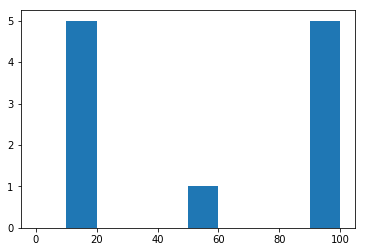

In [20]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

unequal_income = np.array([10, 10, 10, 10, 10, 55, 100, 100, 100, 100, 100])

print('Unequal average: {}'.format(np.average(unequal_income)))
print('Unequal median: {}'.format(np.median(unequal_income)))
print('Unequal sum: {}'.format(np.sum(unequal_income)))

_ = plt.hist(unequal_income, range=(0, 100))

Better average: 55.0
Better median: 55.0
Better sum: 550


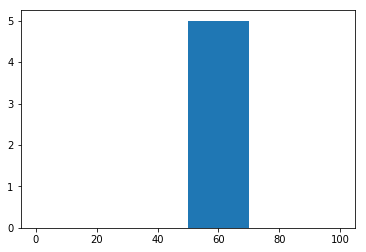

In [10]:
better_income = np.array([50, 50, 50, 50, 50, 60, 60, 60, 60, 60])

print('Better average: {}'.format(np.average(better_income)))
print('Better median: {}'.format(np.median(better_income)))
print('Better sum: {}'.format(np.sum(better_income)))

_ = plt.hist(better_income, range=(0, 100))

## Moving away from point estimates
One first step towards better analysis is to incorporate the *spread* of the data into the analysis. This can be done with two metrics that are still familiar to people with some mathematical background but, for some reason, we tend to use them less: standard deviation and variance.

While the previous example shows two datasets that cannot be differentiated by the metrics chosen, by adding standard deviation and/or variance the nuances between both become clear.

In [11]:
print('Unequal standard dev: {}'.format(np.std(unequal_income)))
print('Unequal variance: {}'.format(np.var(unequal_income)))

print('Better standard dev: {}'.format(np.std(better_income)))
print('Better variance: {}'.format(np.var(better_income)))


Unequal standard dev: 42.90581651605166
Unequal variance: 1840.909090909091
Better standard dev: 5.0
Better variance: 25.0


Using metrics related to distribution spread is a clear step forward, but we still have work to do. For instance, how do we know if the difference between two standard deviations is *large enough*? For starters the comparison will be very scale dependent and subtle differences might be very significant in some contexts, while not so much in others (note that we have not talked about normalization of the data).

Everything in data analysis can be seen as layers that need to be explored further. From this type of metric a good rule of thumb is to analyze the change in order(s) of magnitude from one metric to the other. Note that in the sample case both the standard deviation and variance have 1 and 2 orders of magnitude changes between each other. It should be pretty non controversial that under those circumstances there is something going on.

## Distributions are your friends, but first...
If using standard deviation and variance is not enough, then what is? In an ideal world we would think about every single column that describes our problem of interest as a distribution. We would abandon the notion of using point estimates and whenever we want to *compare two columns* we would do hypothesis testing over both of them (more on this later). There are several practical road blocks to being able to do this so we need some basic tools that allow us to avoid going into full *the world is just distributions* mode, while still getting us close enough.

Thus, before distributions, we also like to look at **quantiles**. The two most famous divisions are **quartiles** and **percentiles** but, technically, any uniform set of buckets that divide the data are considered quantiles. To illustrate this concept, let us draw a hypothetical distribution of male individuals and their heights from two different countries on Earth (based on the always reliable [Wikipedia](https://en.wikipedia.org/wiki/List_of_average_human_height_worldwide)).

Dutch quartiles => Q1: 177.98789658757937 Q2: 184.80290932715246 Q3: 191.25407105159604
Bolivian quartiles => Q1: 153.92730130021673 Q2: 160.40096482418767 Q3: 167.28616529017975


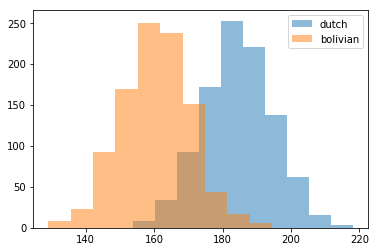

In [12]:
dutch = np.random.normal(184, 10, 1000)
bolivian = np.random.normal(160, 10, 1000)

print('Dutch quartiles => Q1: {} Q2: {} Q3: {}'.format(
      np.percentile(dutch, 25),
      np.percentile(dutch, 50),
      np.percentile(dutch, 75)))

print('Bolivian quartiles => Q1: {} Q2: {} Q3: {}'.format(
      np.percentile(bolivian, 25),
      np.percentile(bolivian, 50),
      np.percentile(bolivian, 75)))

plt.hist(dutch, bins=10, alpha=0.5, label='dutch')
plt.hist(bolivian, bins=10, alpha=0.5, label='bolivian')
plt.legend(loc='upper right')
plt.show()

The choice of countries was made in order to have a clear example and it may be apparent that the 2 simulated populations are different. However, if we always used deciles, for example, we would be comparing 9 different values against other 9, which is much better than comparing single point averages.

As we mentioned before, the best approach we can take here is to analyze full distributions and compare whether or not they are significantly different.

## Hypothesis testing
Every column in a dataset follows some distribution or, at least, comes from some distribution that we may or may not know. The final and most appropriate way of reasoning about columns is determining what distribution originated them and then do any form of comparison and analysis based on the properties of the distribution.

Before, we assumed that heights are normal because many measures in nature are. However, it is common not to have enough domain knowledge about a variable to intuitively know what distribution originated it. Two common tools to do this are normality tests or a KS-test (as in Kolmogorov-Smirnov). The former, as its name suggests, checks whether a sample follows a Gaussian distribution while the second one is a more general goodness-of-fit test. We will not dive into the statistical details but it is important that we know that they exist as tools.

For example, using `scipy.stats.normaltest` we can corroborate that the two height samples we generated are indeed normal. The null hypothesis here is that the sample does follow a normal distribution so we obtain p-values that are large (not close to zero), which requires us to "accept the null". If we were to obtain very small p-values it means that the distributions are not normal.

In [13]:
import scipy.stats as sps

bolivian_normal_test = sps.normaltest(bolivian)
dutch_normal_test = sps.normaltest(dutch)

print('Bolivian normal p-value: {} Dutch normal p-value: {}'.format(
    bolivian_normal_test.pvalue, dutch_normal_test.pvalue))

Bolivian normal p-value: 0.5022576247628789 Dutch normal p-value: 0.9818220040397851


Another common operation is to determine whether two samples are the same. In practical terms this mean testing whether or not the means of the two distributions are centered around the same values. There are multiple statistical tests that can be applied but arguably a data scientist's best friend for this task is the t-test.

The following snippet tries Welch's t-test on the Dutch and Bolivian populations generated before. Barring an unlikely sample created by `numpy.random` the p-values returned should be very close to zero, which means that the null hypothesis that the 2 distributions have identical averages must be rejected (i.e. they are not the same).

In [14]:
# False makes it Welch's which doesn't assume same variance or size.
test_result = sps.ttest_ind(dutch, bolivian, equal_var=False)
print('Welch\'s test p-value: {}'.format(test_result.pvalue))

Welch's test p-value: 0.0


In [21]:
# Exercise for attendees:
# Select 2 countries from the Wikipedia list that you think are similar and follow the same procedure
#   - Create a sample assuming normality for each
#   - Since wikipedia does not provide standard deviation use a value between 8-12 centimeters (which is common)
#   - Do Welch's t-test

# Regardless of country, for a standard deviation of 10 cm, determine how many centimeters apart 2 sampled populations
# need to be in order to get consistent p-values that suggest similarity (i.e. large p-values, not close to zero)

# Machine learning in action
Following the practical theme of this workshop, in this section we will assume that people have some notion as to what learning is and we will try to address some rules of thumb and recommendations to solve practical problems using ML.

## Selecting a model family
Learning has 3 main branches. We will briefly talk about each choosing a real life example to highlight what it is and when a Data Scientist would try to use such a model in their day to day work.

### Unsupervised learning

If we have thousands of family pictures that we want to classify but we have no idea where to start then we first need to group data in some coherent fashion. For instance, we may want to group photos where the same family member appears or by rough location (e.g. at the beach). As most people with smart phones know you never get to classify your pictures because there is too many of them.

Wouldn't it be nice to have someone group them for you. That is what unsupervised learning tries to do: without the **supervision** of a human, an algorithm will create groups that (hopefully) have some meaning. The canonical unsupervised learning technique is called **clustering**.

In general, unsupervised learning is more explorational and we will use it when we are exploring a domain that we have no certainty about either what we want or what each example in a dataset are. This type of learning can be a precursor to supervised learning, since annotating groups of entities can be easier than annotating every single individual in a dataset.

### Supervised learning

Maybe I have some spare time to classify 100 of my pictures. Maybe 500? I can come up with interesting annotations for each picture, ranging from names, locations, situations, and so on.

Supervised learning models can take over a task where a human (or some other entity) assigns some ground truth value to each of the examples in a dataset and then extrapolates what other unseen examples should be treated as. The presumption here is we can start from a well curated *training* dataset that we know everything for and later in time there will be more instances of the problem that we will know what to do about, because we learned from the training phase.

Two broad types of supervised learning exist: predicting a value (such as the number of people in a picture) and predicting annotations (e.g. beach, office). Thus, we use supervised learning models when we want to estimate the salary paid to a particular type of job, or when we want to predict whether or not a customer of some profile type will buy a product or not.

The main problem with using this type of algorithms in practice is having annotated data. There are companies that dedicate themselves to just annotating data that then gets fed into ML pipelines for model creation. To use supervised models we **must** have data and organizations must first solve this challenge before trying to get into applying ML.

### Reinforcement learning

We will not dwell on this one because, compared to the previous ones, it is much less mature. The essence of this type of learning is that an *artificial intelligence agent* can learn the general rules about a domain (normally called a policy) that allows it to provide answers, navigate a space, etc.

In recent years there have been prominent advances in board-like games being played by agents trained with a combination of reinforcement learning and supervised learning. Most prominently [AlphaGo](https://deepmind.com/research/alphago), developed by Google's DeepMind, was able to become arguably the best player on the planet in the very complicated game of Go.

## Applying a model
Once we have identified our type of problem, and selected which of the 3 branches of learning can help us, we can build a model and use it. As mentioned before, the purpose of this workshop is to focus on the practical implications of each data science competency, and not to go into details about particular learning models. Because of that we will focus on supervised learning only, specifically classification problems, since they are probably the most mature subset.

Python has been our weapon of choice in no small part due to the vast support for scientific computation and artifical intelligence libraries. One such package called `scikit-learn` focuses on learning, as its name suggests, and its built on top of `numpy` and `scipy` which allows for interoperation between libraries (`tensorflow` is also a good option in Python).

The package contains a handful of datasets that can be used for simple examples and thus we will use one of them: the Iris dataset. Iris is a type of flower that can be described by the petal and sepal (the green base that holds the petals) length and width. Different measures define different type of Iris varieties. The dataset contains 3 types of Iris and the 4 features described.

In [16]:
from sklearn import datasets

sample_data = datasets.load_iris()

print('Iris features\n')
print(sample_data.feature_names)

print('Total Samples: {}'.format(sample_data.data.size))

print('\n5 Iris examples\n')

# Use different indexes to show different types (they are sorted in the returned set)
for i in [0, 20, 70, 90, 115]:
    print('Sepal length/width: {}/{} Petal length/width: {}/{} Iris Type: {}'.format(
            sample_data.data[i, 0],
            sample_data.data[i, 1],
            sample_data.data[i, 2],
            sample_data.data[i, 3],
            sample_data.target[i]
        ))

Iris features

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Total Samples: 600

5 Iris examples

Sepal length/width: 5.1/3.5 Petal length/width: 1.4/0.2 Iris Type: 0
Sepal length/width: 5.4/3.4 Petal length/width: 1.7/0.2 Iris Type: 0
Sepal length/width: 5.9/3.2 Petal length/width: 4.8/1.8 Iris Type: 1
Sepal length/width: 5.5/2.6 Petal length/width: 4.4/1.2 Iris Type: 1
Sepal length/width: 6.4/3.2 Petal length/width: 5.3/2.3 Iris Type: 2


We can then train a model to predict what type of Iris we have based on the petal and sepal dimensions. We will use both Logistic Regression and Decision Tree classifiers mostly to illustrate that, from the outside, using one or another Machine Learning model is pretty well abstracted by the library (and other libraries do a similarly good job).

While we keep default options for each classifier in this example, being able to tune them is where the real value of a data scientist can lie. The interface may be similar, but the specific parameters for each model and the circumstances under which one performs better than the other can vary.

The following snippet trains both models and then reconstructs what the predicted labels are.

In [17]:
from sklearn import linear_model, tree

logreg = linear_model.LogisticRegression()
logreg.fit(sample_data.data, sample_data.target)
logreg_predictions = logreg.predict(sample_data.data)
print('Logistic Regression Predictions\n')
print(logreg_predictions)

dt = tree.DecisionTreeClassifier()
dt.fit(sample_data.data, sample_data.target)
dt_predictions = dt.predict(sample_data.data)
print('\nDecision Tree Predictions\n')
print(dt_predictions)

# Calculate accuracy
logreg_correct = 0
dt_correct = 0

for i in range(0, sample_data.target.size):
    if sample_data.target[i] == logreg_predictions[i]:
        logreg_correct += 1
    if sample_data.target[i] == dt_predictions[i]:
        dt_correct += 1

print('\nLogistic Regression Accuracy: {}\n'.format(logreg_correct / sample_data.target.size))
print('Decision Tree Accuracy: {}\n'.format(dt_correct / sample_data.target.size))

Logistic Regression Predictions

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]

Decision Tree Predictions

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]

Logistic Regression Accuracy: 0.96

Decision Tree Accuracy: 1.0



## Evaluating a model

In the example we compute accuracy since it is a natural measure to determine whether or not the model was able to correctly classify examples. We calculated that value over the set of the exact same examples we used for fitting. While accuracy is not the best measure we could use (e.g. confusion matrices) evaluating the same training set is a big no no in learning.

The main problem is that this value *should be good* and it will only reflect how well the model adjusted to the test data, but not how well it generalizes. To address this a better protocol for evaluation involves splitting the data in different ways.

### Training and testing

At minimum, we want to split the data in 2:
- Training set: Some percentage of the data (possibly 50% at random) is fed into the fitting function and the classifier is saved.
- Testing set: The rest of the data is fed into the predicting function. Since the fitting function never saw these data, and assuming the original data set was split in a way that both partitions are representative of the population, if we get good metrics then there is hope that the model is indeed good.

### Training, validation and testing

A second step in the right direction is to have 3 sets: training, validation and test. These can be even splits but ratios like 40-40-20 are common too. The main drawback with using just 2 datasets is that we will likely try to run the model, tweak it, run again, tweak, and so on. By doing this there is the risk that we are manually overfitting to the testing set. The third set accounts for this problem with one big restriction: it should ideally be used only once for a final evaluation of the model. The third set becomes a sort of acid test for the model.

This also suggests that it is good practice not to tweak models excessively. Sound reasoning before creating models can trump obsessive back and forths between training and testing.

To the very purist if the final test is not successful, and we do not want to throw the model away, then we need to find completely fresh data.

### K-fold cross-validation
A third and final protocol for evaluation is an extension of the second one and it is valled K-fold cross validation. We still have a third and final testing set that we will save until the end. However, instead of having just 2 sets for training and validation, we will make those two sets one (at least it seems like it) and then we will create K different training/validation pairs. If we have 1000 examples, we will divide them into say 10 groups (K=10) of 100 and we will train and test 10 different models. The first iteration we will use subgroups 1 through 9 for training and subgroup 10 for testing. In the second we may use subgroup 1 for testing and 2-10 for training.

By doing this we try to compensate for the possibility that a particular selection of training and testing sets is causing some bias in the model.

After we have finished all iterations the *final model* can be created by averaging the K runs. The very final acid test evaluation against the holdout third set would be done using that averaged model.


In [18]:
# Exercise for attendees: use the load_wine dataset in sklearn.datasets but this time
# use training, testing and validation sets.

# Experiment design
For some this is the best part of being a data scientist. You work in a particular domain, you analyze the data, you find patterns, you create models to synthesize data and automate the decision making process but that is arguably all based on past data.

How do you generate new data? How do you test whether or not a change to your website will have the desired effect? For an online retailer, for instance, will adding a scale of 1-10 in reviews generate more or less sales than a 5 point scale?

These questions fall under the competency of experiment design that should take into account how to define a population of interest, how to sample from it, how to perform the test and, finally, how to analyze it.

## Defining population and sampling
A natural way of relation to this task is to think about political polling. When an election approaches polling companies need to contact a small subset of the population and ask them who they will vote for. The best possible study one can make is a census, where the population and the sample become the same. Because the cost of a census is high, we want to be able to interview a (relatively) small subset of the whole population that will yield results that match the thinking of the whole population.

A first approach to sampling is selecting completely at random. If we draw enough samples in theory the sample should be correctly distributed and will contain enough examples for all possible values, for all possible columns. In the case of election polling, we want to sample a number of people from each age range proportional to the total number of citizens in each of those ranges. We want to sample a number of low income and high income people that mimic the ratio in the whole country.

Sampling is borderline a craft because it is rare that we can get a representative sample across the most important features just by randomly selecting examples.

### Stratified sampling

While there is debate among statistician about the best way to sample, one that combines practical considerations and shound theory is stratified sampling. It is basically a 2-step protocol to divide the population into a few categories (for some definition of *few*) that we want to have representation for and, within each category, we do apply a systematic way of sampling, possibly just truly random.

The main difference between overall random and stratified lies in our willingness to accept a sample that does not have a single person between the ages of 18-25 in a sample, simply because a truly random sample allows for the possibility that no young people are selected. What stratified says is that we want to at least populate some important categories and after that everything is fair game.

Socio-economic features are prevalent in election polling, but those are not the only person descriptors that can interest a data scientist. For instance, if we are doing user experience research on a website, features related to tech literacy are probably much more important than anything else. Thus we probably want to force some people to be complete computer geeks, others who are able technology users but struggle sometimes, but also allowing some people like the instructor's parents who can struggle knowing whether a photo was blatantly photo-shopped or if it is real.

## A/B testing
A/B testing refers to the notion that we can have two groups of users, patients, humans, and we want to determine what their reaction would be to some event or feature (A or B). In the case of 5 or 10 star reviews mentioned before, we want to expose half of them to the 5 point scale and half to the 10 point one. If the samples are good, based on the criteria defined in the previous section, we should get a good mix of individuals exposed to both treatments. Once we finish the experiment we could measure, for example, what's the average purchase of clients that see 5 versus the ones that see 10.

Normally we should define a collection period, sit back and wait for the data. Conversely, we should **not** try to check on the partial results of the experiment every few hours. This will bias us or create preconceived notions that will not be beneficial for any analytics that are performed after the experiment. In particular we tend to be victims of confirmation bias, which is our tendency to give data an interpretation that is consistent with what we think, and not what the data truly says.

### Traffic experiments
A particular instance of this problem happens when we want sample requests to a Web server or website, in general. This is a good practical example of how to apply different treatments. If our website has a good enough amount of traffic, we can use tricks like using the session id assigned by the system modulo 100. We apply the A treatment to sessions between 0 and 49 and the B treatment to 50 to 99.

We could presumably then sample uniformly and the data should be correctly distributed across the different descriptors that we care about.

It is good practice for every system to have a form of experiment management layer. While we are running the 5 versus 10 star experiment, we may also want to run another one with a yellow "Buy" button versus a green one. There are more elaborate ways to split experiments across the whole population but a simple one can be to assign 20% (split into 10& and 10%) to the first experiment and assign a different 20% range to the second experiment.

## Evaluation
After the data have been collected we want to understand the differences caused by both treatments. In its most naive form we want to compare if the average purchase with a 5 point scale is \$25.33 and with a 10 pointer it is \$26.77 does that really mean that a 10 point scale is more profitable?

Since we already discussed hypothesis testing we do not need to motivate the discussion too much. What we do need is a way to generate a distribution of those means to run hypothesis testing on. Two classic techniques that are very much valid for this type of analysis are [jackknife sampling](https://en.wikipedia.org/wiki/Jackknife_resampling) and [boostrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics%29).

The essence of both is similar to K-fold cross-validation because we create multiple distributions by sampling from the distribution obtained from the experiment. If we use the whole population to compute an average we only have a point estimate, however, if we remove some of them and compute the average with the rest we could have a different average. If we do this repeatedly we will have a distribution of averages that can then be used for hypothesis testing.

# Visualization and reporting basics
A data scientist should be able to communicate results to other people. The canonical way we do this is by creating visualizations of the data that are easy to understand. Most likely it is not within their responsibilities to create a graphical library to have three-dimensional plotting, but it probably is to be a power user of a reporting tool, or to be able to write SQL queries to create custom views of the data.

This competency is much more related to the user experience that others have when accessing and understanding the reports created by the data scientist than it is to being able to create a deeply technical product. The utmost responsibility that we have is to surface useful data to the rest of an organization in a way that allows us to correct errors, be more efficient, have better strategic thinking, and so on.

## Consumer types
It is useful to think about the profile of people that will visualize the data. One potential classification is:

- Casual users: These are users that probably do not want custom reports and only need to visualize data every now and then. They are probably contempt with having read-only dashboards that help them in their day-to-day work. People in the same role, who are casual users, probably have the same reporting needs.

- Power users (the pivoters): One level above casual users we have what we can consider reporting power users. These are people who tend to be more tech savvy, they find standard reports useful but sometimes they need to download a copy of the data and do a pivot table manually because the current reports do not work for their needs. Some of them may even have some SQL knowledge to write very basic queries. The data scientists role is to expose as much data as needed so that the power users can do manipulation of the data on top.

- Power coders: Probably developers who can probably extract any piece of information if given a direct connection to the data source. Arguably we do not need to worry about this type of user other than making sure there is standardization across the code created to access data directly and whatever scripts this role develops.

Knowing what type of consumer we have is useful to define the granularity of the data exposed and the level of control we need to give them.

## Tools
The most basic reporting tool we have is `matplotlib`. However, this is probably only useful to programmers and the majority of consumers are probably not coders. Having said that, tools like the very one we are using right now, Jupyter, can help us use this library as a way of incorporating into a report.

On top of this type of visualization library we tend to find full systems that we can use to make sense of the data through reporting. Some desirable characteristics of the tool are:

- Easy to use
- Allows the user to define custom views
- It provides table reports with pivoting mechanisms
- It can join multiple sources of data into a single report
- Secure, both from the outside access point of view but also from protecting data on a need-to-know basis perspective.

Remember that the choice of tool will directly impact all consumers of your data.

# Configuration details
To run the code samples, outside of the Jupyter environment setup, it is necessary for the person to install Python 3 locally and install the following modules (`pip` commands given for convenience):

```bash
pip3 install findspark

pip3 install matplotlib
pip3 install numpy
pip3 install pandas
pip3 install scipy
pip3 install sklearn
```

During the workshop we also used [Spark](https://spark.apache.org/) and [PostgreSQL](https://www.postgresql.org/). Both are (mostly) well documented and the community is large enough that most common problems are crowd-solved in sites like StackOverflow, also.